In [1]:
import batoid
import galsim
from donut_sims import wfsim

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# some initial setup
# we'll do r-band for this demo
bandpass = galsim.Bandpass("LSST_r.dat", wave_type="nm")
telescope = batoid.Optic.fromYaml("LSST_r.yaml")
pixel_scale = 10e-6 # microns / pixel

# setup observation parameters
# these are plausible numbers from Josh
observation = {
    "zenith": 30 * galsim.degrees,
    "raw_seeing": 0.7 * galsim.arcsec, # zenith 500nm seeing
    "wavelength": bandpass.effective_wavelength, # nm
    "exptime": 15.0, # seconds
    "temperature": 293.0, # Kelvin
    "pressure": 69.0, # kPa
    "H2O_pressure": 1.0, # kPa
}

# setup atmospheric parameters
atm_kwargs = {
    "screen_size": 819.2,
    "screen_scale": 0.1,
    "nproc": 6, # create sceens in parallel using this many CPUs
}

In [3]:
# We loaded the fiducial telescope - now let's perturb it out of alignment
# and misfigure the mirrors a little bit

# the big question is how much to perturb each degree-of-freedom
# for this demo, we will not dwell on this too much

seed = 0
rng = np.random.default_rng(seed)

# Now we'll perturb the main mirror
# we should use actual mirror modes, but for now, we'll just use Zernikes
M1M3_modes = rng.uniform(-1e-1, +1e-1, size=23) # waves
M1M3_modes *= bandpass.effective_wavelength * 1e-9 # meters

M1M3_surface_perturbation = batoid.Zernike(
    M1M3_modes,
    R_outer=telescope["M1"].obscuration.original.outer,
)

perturbed = telescope.withSurface(
    "M1",
    batoid.Sum([
        telescope["M1"].surface,
        M1M3_surface_perturbation,
    ])
)
perturbed = perturbed.withSurface(
    "M3",
    batoid.Sum([
        telescope["M3"].surface,
        M1M3_surface_perturbation,
    ])
)

# M2 bends independently from M1M3
M2_modes = rng.uniform(-1e-1, +1e-1, size=23) # waves
M2_modes *= bandpass.effective_wavelength * 1e-9 # meters

M2_surface_perturbation = batoid.Zernike(
    M2_modes,
    R_outer=telescope["M2"].obscuration.original.outer,
)
perturbed = perturbed.withSurface(
    "M2",
    batoid.Sum([
        telescope["M2"].surface,
        M2_surface_perturbation,
    ])
)

# To make donuts, we need to be intra-focal or extra-focal.
# To simulate normal science operations mode, shift the detector:
intra = perturbed.withGloballyShiftedOptic(
    "Detector", [0, 0, -1.5e-3]
)
extra = perturbed.withGloballyShiftedOptic(
    "Detector", [0, 0, +1.5e-3]
)

intra_simulator = wfsim.SimpleSimulator(
    observation,
    atm_kwargs,
    intra,
    bandpass,
    shape=(160, 160),
    rng=rng
)


extra_simulator = wfsim.SimpleSimulator(
    observation,
    atm_kwargs,
    extra,
    bandpass,
    shape=(160, 160),
    rng=rng
)

# Now we can choose some parameters for a star and start simulating
# First, choose a field angle.  At the moment, the simulator code only 
# works close to the boresight direction, so just use that.  I'll 
# extend that soon.
thx = np.deg2rad(0)
thy = np.deg2rad(0)

# We also want to simulate chromatically.  We could fetch an actual 
# stellar SED for this, but it's easier and probably always good enough
# to just use a black body with a reasonable temperature.
star_T = rng.uniform(4000, 10000)
sed = wfsim.BBSED(star_T)

# We also need a flux (which needs to be an integer):
flux = rng.integers(1_000_000, 2_000_000)

intra_simulator.add_star(thx, thy, sed, flux, rng)
extra_simulator.add_star(thx, thy, sed, flux, rng)

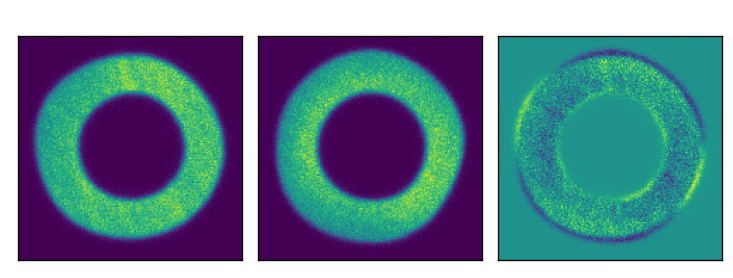

In [4]:
fig, axes = plt.subplots(1, 3, dpi=120, constrained_layout=True)

axes[0].imshow(extra_simulator.image.array, origin="lower")
axes[0].set_title("Extra", color="w")

axes[1].imshow(intra_simulator.image.array, origin="lower")
axes[1].set_title("Intra", color="w")

axes[2].imshow(extra_simulator.image.array - intra_simulator.image.array, origin="lower")
axes[2].set_title("Extra - Intra", color="w")

for ax in axes:
    ax.set(xticks=[], yticks=[])

plt.show()

In [5]:
# Finally, what were the actual Zernike's for the perturbed telescope
# we generated?  Get that using batoid.zernike:
zs = batoid.zernike(
    perturbed, 
    thx, thy, 
    bandpass.effective_wavelength*1e-9  # batoid wants meters,
)
zs *= bandpass.effective_wavelength # waves -> nm

Text(0.5, 0, 'Zernike Index (Noll)')

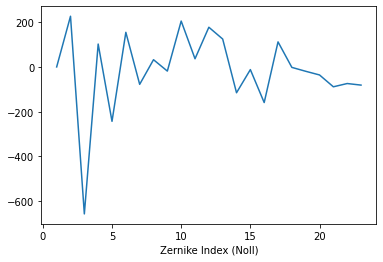

In [6]:
plt.plot(np.arange(1, len(zs)+1), zs)
plt.xlabel("Zernike Index (Noll)")

In [7]:
np.savez(
    "one_intra_and_extra.npz", 
    intra=intra_simulator.image.array,
    extra=extra_simulator.image.array,
    zernikes=zs,
)

Now I will try to fit this pair with the wavefront estimation pipeline

In [10]:
npz = np.load("one_intra_and_extra.npz")

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)
from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
import lsst.afw.image as afwImage
from lsst import geom
from lsst.ts.wep.Utility import CamType, DefocalType, getConfigDir

import os
from lsst.ts.wep.cwfs.Instrument import Instrument

In [2]:
%matplotlib inline

In [3]:
# properties of the telescope
PLATE_SCALE = 0.2  # arcsecs / pixel

# angular conversion
ARCSECS_PER_RADIAN = 206_265
PIXELS_PER_RADIAN = ARCSECS_PER_RADIAN / PLATE_SCALE

# configure the instrument
instDataPath = os.path.join(getConfigDir(), 'cwfs', 'instData')
inst = Instrument(instDataPath)
radius_of_donut = 126
inst.config(CamType.LsstCam, radius_of_donut)

In [12]:
intra_stamp = DonutStamp(
    afwImage.MaskedImageF(afwImage.ImageF(npz["intra"])),
    geom.SpherePoint(0, 0, geom.radians),
    geom.Point2D(0, 0),
    DefocalType.Intra,
    "R22_S11",
    "LSSTCam",
)

extra_stamp = DonutStamp(
    afwImage.MaskedImageF(afwImage.ImageF(npz["extra"])),
    geom.SpherePoint(0, 0, geom.radians),
    geom.Point2D(0, 0),
    DefocalType.Extra,
    "R22_S11",
    "LSSTCam",
)

In [37]:
# configure the Zernike estimator
zernConfig = EstimateZernikesCwfsTaskConfig()
zernTask = EstimateZernikesCwfsTask(config=zernConfig)

# estimate zernikes
est_zernikes = zernTask.estimateZernikes(
    DonutStamps([extra_stamp]), 
    DonutStamps([intra_stamp]),
)

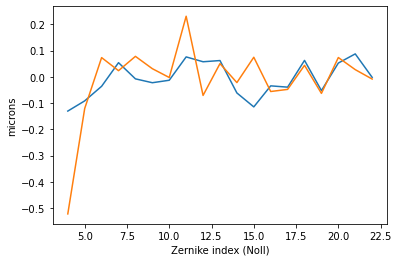

In [42]:
plt.plot(np.arange(4, 23), est_zernikes[0])
plt.plot(np.arange(4, 23), npz["zernikes"][4:]/1000)
plt.xlabel("Zernike index (Noll)")
plt.ylabel("microns")
plt.show()